In [40]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from category_encoders import TargetEncoder
from sklearn.metrics import roc_auc_score, recall_score, f1_score, confusion_matrix, precision_score
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# ! pip install imbalanced-learn

# Loading Data

In [3]:
df = pd.read_csv('dataset.csv', sep=';')

In [4]:
df_final_uotput = df[df['default'].isna()]

In [5]:
df = df[~df['uuid'].isin(df_final_uotput['uuid'])]

# Missing Values

In [6]:
# with zero to anotate missing category
df['account_status']  = df['account_status'].fillna(0)

# replacing with 1 because the split by target variable looks very similar to the one from cat=1 
df['account_worst_status_0_3m']  = df['account_worst_status_0_3m'].fillna(1)
df['account_worst_status_3_6m']  = df['account_worst_status_3_6m'].fillna(1)
df['account_worst_status_6_12m']  = df['account_worst_status_6_12m'].fillna(1)
df['account_worst_status_12_24m']  = df['account_worst_status_12_24m'].fillna(1)

# replacing with 1 because the split by target variable looks very similar to the one from cat=1 
df['worst_status_active_inv'] = df['worst_status_active_inv'].fillna(1)

# with zero because the distribution has a long-tail (most values are close to 0)
df['account_days_in_dc_12_24m']  = df['account_days_in_dc_12_24m'].fillna(0)
df['account_days_in_rem_12_24m']  = df['account_days_in_rem_12_24m'].fillna(0)
df['account_days_in_term_12_24m']  = df['account_days_in_term_12_24m'].fillna(0)

# replacing with 0 because cat = 1 and 2 result in default=0 most of the time
# unlike users with NaN values
df['num_arch_written_off_0_12m']  = df['num_arch_written_off_0_12m'].fillna(0)
df['num_arch_written_off_12_24m']  = df['num_arch_written_off_12_24m'].fillna(0)

df['num_active_div_by_paid_inv_0_12m']  = df['num_active_div_by_paid_inv_0_12m'].fillna(0)

# using median because the distribution is slightly skewed to the right
df['avg_payment_span_0_3m'] = df['avg_payment_span_0_3m'].median()
df['avg_payment_span_0_12m'] = df['avg_payment_span_0_12m'].median()

# no particular signal and to many values to replace
df = df.drop(['account_incoming_debt_vs_paid_0_24m'], axis=1)

# this is assuming that other fields can not have missing values
df = df.drop(['uuid'], axis=1)

# Test, Val, Train Split 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df, df['default'], test_size=0.2, random_state=1)

In [8]:
# X_train['time_hours'].head()

In [9]:
X_train, X_val, y_train, y_val = train_test_split(df, df['default'], test_size=0.25, random_state=1)

# Target encoding of categorical features

In [10]:
COLS_TO_ENCODE = ['merchant_group', 'merchant_category', 'name_in_email']

encoder = TargetEncoder()
encoder = encoder.fit(X_train[COLS_TO_ENCODE], X_train['default'])

X_train[COLS_TO_ENCODE] = encoder.transform(X_train[COLS_TO_ENCODE])
X_test[COLS_TO_ENCODE] = encoder.transform(X_test[COLS_TO_ENCODE])
X_val[COLS_TO_ENCODE] = encoder.transform(X_val[COLS_TO_ENCODE])


/home/svujovic/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [11]:
# COLS_TO_NUMERIC = X_train.select_dtypes(include=['object', 'category']).columns

# X_train[COLS_TO_NUMERIC] = X_train[COLS_TO_NUMERIC].apply(pd.to_numeric)
# X_test[COLS_TO_NUMERIC] = X_test[COLS_TO_NUMERIC].apply(pd.to_numeric)
# X_val[COLS_TO_NUMERIC] = X_val[COLS_TO_NUMERIC].apply(pd.to_numeric)

In [12]:
# COLS_TO_NUMERIC

In [13]:
X_train = X_train.drop(['default'], axis=1)
X_test = X_test.drop(['default'], axis=1)
X_val = X_val.drop(['default'], axis=1)

# Baseline

In [14]:
model = XGBClassifier(max_depth=2)
model.fit(X_train, y_train, eval_metric="auc")
y_pred = model.predict(X_test)

print('ROC-AUC:', roc_auc_score(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))
print('R:', recall_score(y_test, y_pred))

print('P:', precision_score(y_test, y_pred))

ROC-AUC: 0.528231232195541
[[17720    14]
 [  247    15]]
R: 0.05725190839694656
P: 0.5172413793103449


I don't consider ACCURRACY because of the massive class disbalance. 

I am looking at ROC-AUC, RECAL and the CONFUSION MATRIX mainly. 

This looks terrible, but kinda what I expected. However, that can be treated.

# Early stopping Train and Val 

I did not do any hyper-param tuning. I would leave that for a later stage. 

The param `scale_pos_weight=100` is passed because of the class imbalance. And it significantly improves the evaluation metrics.

I tried `oversampling`, which gave similar results, but I decided to go with `scale_pos_weight=100` because it is less complex.

In [15]:
model = XGBClassifier(max_depth=2, scale_pos_weight=100)
eval_set = [(X_val, y_val)]
model.fit(X_train, y_train, eval_metric="auc", eval_set=eval_set, verbose=False)

y_pred = model.predict(X_test)

print('ROC-AUC:', roc_auc_score(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))
print('R:', recall_score(y_test, y_pred))

print('P:', precision_score(y_test, y_pred))

ROC-AUC: 0.8213323352649028
[[13563  4171]
 [   32   230]]
R: 0.8778625954198473
P: 0.052260849806862075


Much better! However, we still have a lot of false positives. 

# Feature importance

In [16]:
plt.rcParams["figure.figsize"] = (16, 10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='gain', ylabel='Features'>

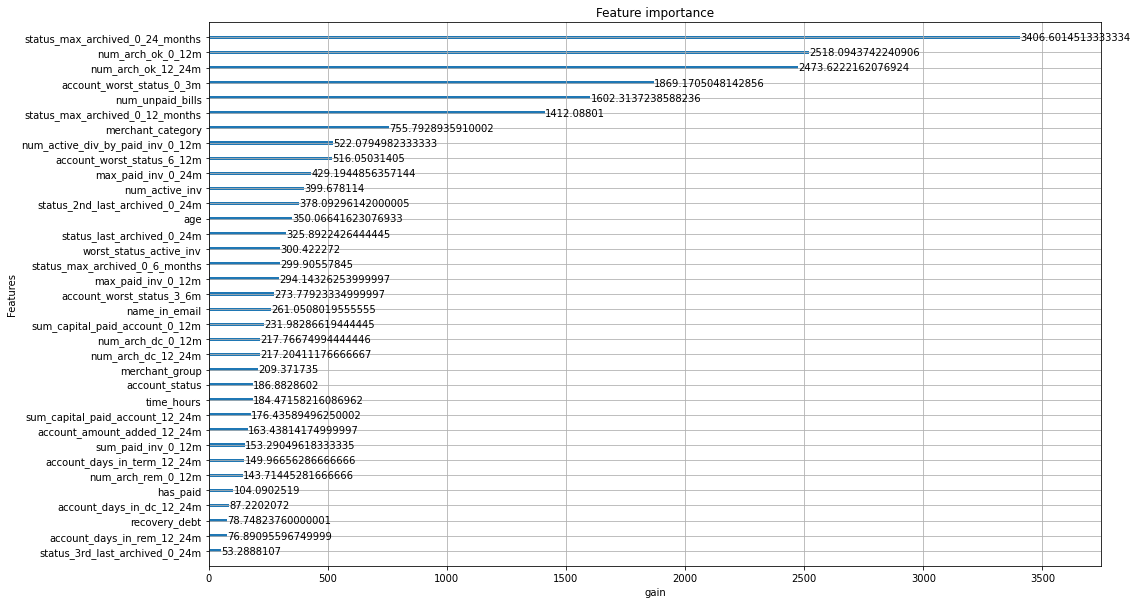

In [17]:
xgb.plot_importance(model, importance_type='gain', xlabel='gain')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='weight', ylabel='Features'>

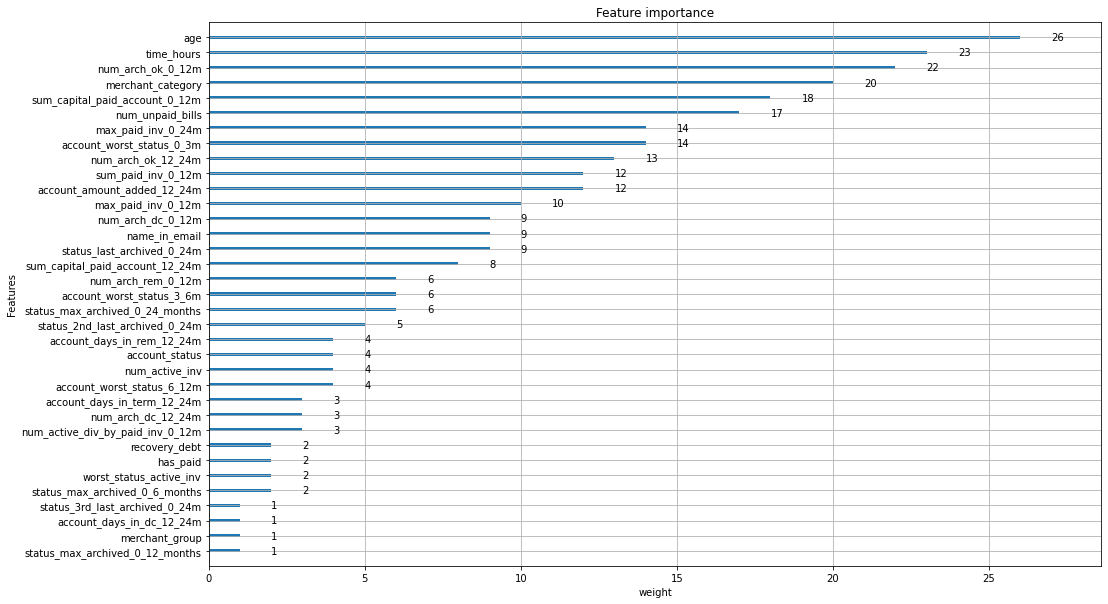

In [18]:
xgb.plot_importance(model, importance_type='weight', xlabel='weight')

# Preparing feature sets for feature selection

Top features based on information gain

In [19]:
fim = model.get_booster().get_score(importance_type="gain")
feature_gain = pd.DataFrame({
    'feature': list(fim.keys()),
    'importance': list(fim.values())
}).sort_values('importance', ascending=False)

In [20]:
XGB_F_GAIN_TOP_30 = feature_gain['feature'].head(30).values
XGB_F_GAIN_TOP_25 = feature_gain['feature'].head(25).values
XGB_F_GAIN_TOP_20 = feature_gain['feature'].head(20).values

In [21]:
fim = model.get_booster().get_score(importance_type="weight")
feature_weight = pd.DataFrame({
    'feature': list(fim.keys()),
    'importance': list(fim.values())
}).sort_values('importance', ascending=False)

In [22]:
XGB_F_WEIGHT_TOP_30 = feature_weight['feature'].head(30).values
XGB_F_WEIGHT_TOP_25 = feature_weight['feature'].head(25).values
XGB_F_WEIGHT_TOP_20 = feature_weight['feature'].head(20).values

#### Sanity check

In [23]:
set(XGB_F_GAIN_TOP_30).difference(XGB_F_WEIGHT_TOP_30)

{'merchant_group', 'status_max_archived_0_12_months'}

In [24]:
set(XGB_F_GAIN_TOP_25).difference(XGB_F_WEIGHT_TOP_25)

{'merchant_group',
 'num_active_div_by_paid_inv_0_12m',
 'num_arch_dc_12_24m',
 'status_max_archived_0_12_months',
 'status_max_archived_0_6_months',
 'worst_status_active_inv'}

In [25]:
set(XGB_F_GAIN_TOP_20).difference(XGB_F_WEIGHT_TOP_20)

{'account_worst_status_6_12m',
 'num_active_div_by_paid_inv_0_12m',
 'num_active_inv',
 'status_max_archived_0_12_months',
 'status_max_archived_0_6_months',
 'worst_status_active_inv'}

# Feature Selection

In [26]:
def evaluate_xgb(X_train,X_val, X_test, y_train, y_val,y_test, feature_list):
    # this function could be cleaner ofc :D 
    X_train = X_train[feature_list]
    X_val = X_val[feature_list]
    X_test = X_test[feature_list]

    model = XGBClassifier(max_depth=2, scale_pos_weight=100)
    eval_set = [(X_val, y_val)]
    model.fit(X_train, y_train, eval_metric="auc", eval_set=eval_set, verbose=False)

    ypred = model.predict(X_test)

    print('roc_auc', roc_auc_score(y_test, ypred))
    print(f"""Confusion matrix
    {confusion_matrix(y_test, ypred)}
    """)
    print('R:', recall_score(y_test, ypred))
    print('P:', precision_score(y_test, ypred))

### ALL Features included

In [27]:
evaluate_xgb(X_train, X_val, X_test, y_train, y_val, y_test, X_train.columns) # all features

roc_auc 0.8213323352649028
Confusion matrix
    [[13563  4171]
 [   32   230]]
    
R: 0.8778625954198473
P: 0.052260849806862075


### Features based on GAIN

In [28]:
evaluate_xgb(X_train, X_val, X_test, y_train, y_val, y_test, XGB_F_GAIN_TOP_30)

roc_auc 0.8230997600675632
Confusion matrix
    [[13558  4176]
 [   31   231]]
    
R: 0.8816793893129771
P: 0.05241660993873383


In [29]:
evaluate_xgb(X_train, X_val, X_test, y_train, y_val, y_test, XGB_F_GAIN_TOP_25) 

roc_auc 0.8158802645024823
Confusion matrix
    [[13505  4229]
 [   34   228]]
    
R: 0.8702290076335878
P: 0.05115548575274848


In [30]:
evaluate_xgb(X_train, X_val, X_test, y_train, y_val, y_test, XGB_F_GAIN_TOP_20) 

roc_auc 0.81483707063759
Confusion matrix
    [[13468  4266]
 [   34   228]]
    
R: 0.8702290076335878
P: 0.050734312416555405


### Features based on WEIGHT

In [31]:
evaluate_xgb(X_train, X_val, X_test, y_train, y_val, y_test, XGB_F_WEIGHT_TOP_30)

roc_auc 0.8171208193688407
Confusion matrix
    [[13549  4185]
 [   34   228]]
    
R: 0.8702290076335878
P: 0.05166553365057784


In [32]:
evaluate_xgb(X_train, X_val, X_test, y_train, y_val, y_test, XGB_F_WEIGHT_TOP_25)

roc_auc 0.8193111606032145
Confusion matrix
    [[13559  4175]
 [   33   229]]
    
R: 0.8740458015267175
P: 0.05199818346957311


In [33]:
evaluate_xgb(X_train, X_val, X_test, y_train, y_val, y_test, XGB_F_WEIGHT_TOP_20)

roc_auc 0.8189076143897477
Confusion matrix
    [[13477  4257]
 [   32   230]]
    
R: 0.8778625954198473
P: 0.05125919322487185


### Feature group `XGB_F_GAIN_TOP_30` seems to slightly incerase ROC AUC, PRECISION and RECAL. It would be useful to cross-validate this at a later stage and maybe try out some othe FS methods.

In [34]:
#features to drop
set(X_train.columns).difference(XGB_F_GAIN_TOP_30)

{'account_days_in_dc_12_24m',
 'account_days_in_rem_12_24m',
 'account_worst_status_12_24m',
 'avg_payment_span_0_12m',
 'avg_payment_span_0_3m',
 'has_paid',
 'num_arch_written_off_0_12m',
 'num_arch_written_off_12_24m',
 'recovery_debt',
 'status_3rd_last_archived_0_24m'}

# Prediction Distributions (For sanity check)

In [35]:
model = XGBClassifier(max_depth=2)

X_train = X_train[XGB_F_GAIN_TOP_30]
X_val = X_val[XGB_F_GAIN_TOP_30]
X_test = X_test[XGB_F_GAIN_TOP_30]

model = XGBClassifier(max_depth=2, scale_pos_weight=100)
eval_set = [(X_val, y_val)]
model.fit(X_train, y_train, eval_metric="auc", eval_set=eval_set, verbose=False)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)


In [36]:
df_predictions = pd.DataFrame({
    'pred': list(y_pred),
    'actual': list(y_test) 
})

In [37]:
df_prediction_facts = pd.DataFrame(y_pred_proba, columns=['no_default','default']).join(df_predictions)

In [38]:
df_prediction_facts.groupby(['actual'])['default'].describe(percentiles=[.8,.9,.95])

,count,mean,std,min,50%,80%,90%,95%,max
actual,,,,,,,,,
0.0,17734.0,0.261242,0.282908,0.000013,0.140902,0.552735,0.721442,0.822045,0.996326
1.0,262.0,0.771425,0.219115,0.004630,0.839382,0.939611,0.972786,0.984168,0.995464


In [39]:
df_prediction_facts[df_prediction_facts['default'] > 0.5].groupby(['actual'])['default'].describe(percentiles=[.1,.2,.8,.9,.95])

,count,mean,std,min,10%,20%,50%,80%,90%,95%,max
actual,,,,,,,,,,,
0.0,4176.0,0.703193,0.130591,0.500086,0.539679,0.575606,0.690510,0.829040,0.896619,0.936660,0.996326
1.0,231.0,0.837742,0.121491,0.504810,0.655200,0.731708,0.860252,0.950055,0.975800,0.985638,0.995464


### My confidence in precision is higher for items with proba > 0.7. Considering the perspective of reducing false positives.

# Imporvements?

* Hyper-param tunning
* Adding a Level 2 Model to reduce false positives, combined with oversampling (maybe)
* Feature selection based on other methods(maybe)
* Trying out CatBoost or Light GBM 